# Assignment 2

In this assignment, you will be working on an image classification task (codename `pnp`) using the transfer learning technique.
The task objective is to determine whether an image contains a person (`pnp` stands for person / non-person) -- a binary classification task.

## Dataset
* Dataset contains 80K images with known labels (for model development), and 20K images with unknown labels (for scoring).
* Dataset has been created from a subset of COCO Dataset, and so all copyrights belong to the original authors: https://cocodataset.org/#termsofuse
* Images have been rescaled and padded to be of shape (224, 224, 3).

While it's possible to create a new model architecture and train a model specifically for this task, that would be expensive in terms of time and cloud resources.
Instead, in this assignment, you will be re-using an pre-trained model's architecture and parameters to save time and cloud resources.

## MobileNet Architecture
* The pre-trained model's name is MobileNetV2: https://arxiv.org/pdf/1801.04381.pdf
* MobileNet is a relatively small network that is designed for usage on mobile devices with limited compute and storage resource.
* It's a great choice for this assignment, since this network can be relatively quickly processed with a single GPU.

## MobileNet Parameters
* Keras provides network architecture and pre-trained parameters: https://keras.io/api/applications/mobilenet/#mobilenetv2-function
* The pre-trained parameters come from the ImageNet 1000-class task, which does not include a person label.
* The lower part of the network can be reused due to the shared hierarchy of visual information..


In [1]:
!wget https://danylo-ucla.s3.us-west-2.amazonaws.com/pnp_dataset.zip
!unzip pnp_dataset.zip >/dev/null 2>&1

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def load_images(folder: str):
    imgs = []

    paths = !find {folder} -type f
    paths = sorted(paths)

    for path in paths:
        with open(path, 'r') as f:
            imgs.append(plt.imread(path))
            
    return np.array(imgs)

In [3]:
train_x = load_images('pnp_dataset/train_x')
score_x = load_images('pnp_dataset/score_x')
train_y = np.load('pnp_dataset/train_y.npy')

In [4]:
train_x.shape, train_y.shape

((80000, 224, 224, 3), (80000,))

In [5]:
train_y[:5]

array([1, 0, 1, 1, 1])

1

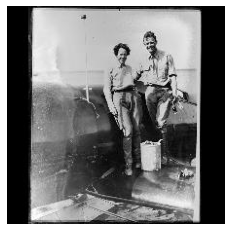

In [6]:
plt.imshow(train_x[0])
plt.axis('off')
train_y[0]

0

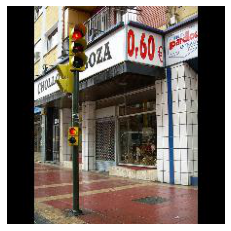

In [7]:
plt.imshow(train_x[1])
plt.axis('off')
train_y[1]

In [ ]:
# Your work from here forward (please document your code as much as possible)

In [8]:
np.random.seed(1)

# we'll split the training data as follows:
    # 40k training samples
    # 20k validation samples
    # 20k test samples
# indices of all 80k images
idx_all = np.array([i for i in range(len(train_x))])
# get indices of 40k images
n_samples_val_test = 40000 # number of random indices
idx_val_test = np.random.choice(idx_all, n_samples_val_test, replace=False)
# drop the sampled indices from the training set indices
idx_train = np.array([i for i in idx_all if i not in idx_val_test])

# should be empty
print([i for i in idx_train if i in idx_val_test])
# should be 40k, 40k
print(len(idx_train))
print(len(idx_val_test))
print()

# get indices of test set from val+test set
n_samples_test = 20000 # number of random indices
idx_test = np.random.choice(idx_val_test, n_samples_test, replace=False)
# drop the sampled indices from the validation set indices
idx_val = np.array([i for i in idx_val_test if i not in idx_test])

# should be empty
print([i for i in idx_val if i in idx_test])
# should be 40k, 20k, 20k
print(len(idx_train))
print(len(idx_val))
print(len(idx_test))
print()

# compy training data so we can rename without messing up subsequent indexing
train_x_init = train_x.copy()
train_y_init = train_y.copy()

# pull the modified training, validation, and test sets from the initial training set
train_x = train_x_init[idx_train,:,:,:]
train_y = train_y_init[[idx_train]]
val_x = train_x_init[idx_val,:,:,:]
val_y = train_y_init[[idx_val]]
test_x = train_x_init[idx_test,:,:,:]
test_y = train_y_init[[idx_test]]

# should be (40000,224,224,3), (20000,224,224,3), (20000,224,224,3)
print(train_x.shape)
print(val_x.shape)
print(test_x.shape)
print()

# should be (40000,), (20000,), (20000,)
print(train_y.shape)
print(val_y.shape)
print(test_y.shape)

[]
40000
40000

[]
40000
20000
20000



/tmp/ipykernel_824/2291998150.py:42: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  train_y = train_y_init[[idx_train]]
/tmp/ipykernel_824/2291998150.py:44: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  val_y = train_y_init[[idx_val]]


(40000, 224, 224, 3)
(20000, 224, 224, 3)
(20000, 224, 224, 3)

(40000,)
(20000,)
(20000,)


/tmp/ipykernel_824/2291998150.py:46: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  test_y = train_y_init[[idx_test]]


In [9]:
# This configures the GPU to be used by Tensorflow.

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

2021-10-12 05:19:26.244316: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-10-12 05:19:26.291057: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-12 05:19:26.292040: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:00:1e.0 name: Tesla K80 computeCapability: 3.7
coreClock: 0.8235GHz coreCount: 13 deviceMemorySize: 11.17GiB deviceMemoryBandwidth: 223.96GiB/s
2021-10-12 05:19:26.292277: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2021-10-12 05:19:26.293974: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-10-12 05:19:26.295613: I tensorflow/stream_executor/platform/defaul

In [10]:
# https://arxiv.org/pdf/1801.04381.pdf
# https://keras.io/api/applications/mobilenet/#mobilenetv2-function
mobile_net = tf.keras.applications.MobileNetV2(
    include_top=False,
    input_shape=(224, 224, 3),
    weights="imagenet"
)

2021-10-12 05:19:31.544490: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2021-10-12 05:19:31.567846: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 2300005000 Hz
2021-10-12 05:19:31.568233: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55e2a91c9090 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-10-12 05:19:31.568259: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2021-10-12 05:19:31.568602: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-12 05:19:31.569424: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:00:1e.0 name: Tes

In [11]:
# Freezes the parameters of the MobileNet layers, so they will not update during training.
# These parameters are initialized to a pre-trained snapshot using the ImagetNet dataset.
mobile_net.trainable = False

In [12]:
mobile_net.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [23]:
model = tf.keras.models.Sequential([
    mobile_net,
    # can try other layers/setting here but this is a good default
    tf.keras.layers.AvgPool2D(pool_size=(7, 7)),
    tf.keras.layers.Flatten(),
    # fully connected classifier layers
    tf.keras.layers.Dense(units=1024, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=256, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    # output layer has only 1 unit since this is a binary classification task
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])

In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
average_pooling2d_2 (Average (None, 1, 1, 1280)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1280)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 1024)              1311744   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)              

In [25]:
model.compile(
    optimizer='adam', # can tweak optimizer settings
    loss='binary_crossentropy',
    metrics=[
        tf.keras.metrics.BinaryAccuracy(
            name="binary_accuracy",
            threshold=0.5
        )
    ]
)
batch_size = 128

In [26]:
model.fit(
    train_x,
    train_y,
    epochs=7, # can tweak this
    batch_size=batch_size,
    validation_data = (val_x, val_y),
    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)]
)

Epoch 1/7
313/313 [==============================] - 135s 431ms/step - loss: 0.6486 - binary_accuracy: 0.6235 - val_loss: 0.6087 - val_binary_accuracy: 0.6602
Epoch 2/7
313/313 [==============================] - 135s 432ms/step - loss: 0.6032 - binary_accuracy: 0.6719 - val_loss: 0.5967 - val_binary_accuracy: 0.6819
Epoch 3/7
313/313 [==============================] - 135s 432ms/step - loss: 0.5906 - binary_accuracy: 0.6826 - val_loss: 0.5871 - val_binary_accuracy: 0.6859
Epoch 4/7
313/313 [==============================] - 135s 432ms/step - loss: 0.5789 - binary_accuracy: 0.6930 - val_loss: 0.5800 - val_binary_accuracy: 0.6939
Epoch 5/7
313/313 [==============================] - 135s 432ms/step - loss: 0.5701 - binary_accuracy: 0.7014 - val_loss: 0.5717 - val_binary_accuracy: 0.7006
Epoch 6/7
313/313 [==============================] - 135s 432ms/step - loss: 0.5621 - binary_accuracy: 0.7088 - val_loss: 0.5751 - val_binary_accuracy: 0.6938
Epoch 7/7
313/313 [===========================

In [27]:
from sklearn.metrics import accuracy_score

# predict on test set
proba_y = model.predict(test_x)
# convert from vector of 1D arrays to vector of floats
proba_y = np.reshape(proba_y, (len(proba_y),))
# convert probabilities to labels
pred_y = np.array(proba_y >= 0.5).astype(int)
# compute accuracy
test_acc = accuracy_score(test_y, pred_y)
# display performance
print(f'Test set accuracy: {test_acc*100:.2f}%')

Test set accuracy: 69.80%


In [28]:
import os 
import pandas as pd

model_dir = 'pnp_model'

os.makedirs(model_dir, exist_ok=True)

# Once you are ready to make the graded submission,
# run the model on the score dataset.
score_y_hat = pd.DataFrame(
    model.predict(score_x, batch_size=batch_size),
    # This is needed to save the file in Parquet format.
    columns=['score']
)

# Now save it to disc as a Parquet file.
score_y_hat.to_parquet(f'{model_dir}/score_y_hat.parquet')

# Next, let's save the model's definition.
import json
with open(f'{model_dir}/keras_model.json', 'w') as f:
    f.write(json.dumps(json.loads(model.to_json()), indent=True))

# Finally, let's save the learned parameters.
model.save_weights(f'{model_dir}/keras_parameters.h5')

# You now have the following files to be uploaded to Moodle:
# 1. This notebook and any other Python code you used to train the final model.
# 2. keras_model.json -- the model's definition
# 3. keras_parameters.h5 -- the model's trained parameters
# 4. score_y_hat.parquet - the model's output on the score dataset